In [1]:
import numpy as np
import pandas as pd
import os, re
import matplotlib.pyplot as plt
from math import sqrt
from numpy import concatenate
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
# models
from sklearn.ensemble import GradientBoostingClassifier
# design network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from matplotlib import pyplot

%matplotlib inline

Using TensorFlow backend.


In [2]:
train = pd.read_csv('gcTrianingSet.csv')

In [3]:
train['CUMSUM_cputime'] = train['cpuTimeTaken'].cumsum(axis = 0)

In [4]:
new = train[train['gcRun'] == True]

In [5]:
new['query token'].unique()

array(['token_8', 'token_15', 'token_23', 'token_30', 'token_39',
       'token_44', 'token_45', 'token_53', 'token_63', 'token_70',
       'token_82', 'token_65', 'token_19', 'token_13', 'token_58',
       'token_10', 'token_54', 'token_62', 'token_40', 'token_9',
       'token_36', 'token_84', 'token_78', 'token_42', 'token_87',
       'token_24', 'token_67', 'token_4', 'token_69', 'token_50',
       'token_1', 'token_74', 'token_48', 'token_85', 'token_31',
       'token_75', 'token_33', 'token_11', 'token_86', 'token_76',
       'token_20', 'token_22', 'token_49', 'token_41', 'token_18',
       'token_2', 'token_37', 'token_81', 'token_14', 'token_56',
       'token_73', 'token_55', 'token_47', 'token_61', 'token_7',
       'token_27', 'token_17', 'token_38', 'token_32', 'token_89',
       'token_43', 'token_5', 'token_21', 'token_29', 'token_28'], dtype=object)

In [6]:
train['query token'].unique()

array(['token_1', 'token_2', 'token_3', 'token_4', 'token_5', 'token_6',
       'token_7', 'token_8', 'token_9', 'token_10', 'token_11', 'token_12',
       'token_13', 'token_14', 'token_15', 'token_16', 'token_17',
       'token_18', 'token_19', 'token_20', 'token_21', 'token_22',
       'token_23', 'token_24', 'token_25', 'token_26', 'token_27',
       'token_28', 'token_29', 'token_30', 'token_31', 'token_32',
       'token_33', 'token_34', 'token_35', 'token_36', 'token_37',
       'token_38', 'token_39', 'token_40', 'token_41', 'token_42',
       'token_43', 'token_44', 'token_45', 'token_46', 'token_47',
       'token_48', 'token_49', 'token_50', 'token_51', 'token_52',
       'token_53', 'token_54', 'token_55', 'token_56', 'token_57',
       'token_58', 'token_59', 'token_60', 'token_61', 'token_62',
       'token_63', 'token_64', 'token_65', 'token_66', 'token_67',
       'token_68', 'token_69', 'token_70', 'token_71', 'token_72',
       'token_73', 'token_74', 'token_75', 'tok

In [7]:
train.head()

,initialUsedMemory,initialFreeMemory,query token,gcRun,gcInitialMemory,gcFinalMemory,gcTotalMemory,userTime,sysTime,realTime,cpuTimeTaken,finalUsedMemory,finalFreeMemory,CUMSUM_cputime
0,4.249634,2.999878,token_1,False,0.0,0.0,0.0,0.0,0.0,0.0,0.371230,4.409714,2.839798,0.371230
1,4.409720,2.839792,token_2,False,0.0,0.0,0.0,0.0,0.0,0.0,0.220883,4.482361,2.767151,0.592113
2,4.482361,2.767151,token_3,False,0.0,0.0,0.0,0.0,0.0,0.0,0.141776,4.542626,2.706886,0.733889
3,4.542626,2.706886,token_4,False,0.0,0.0,0.0,0.0,0.0,0.0,0.156459,4.616293,2.633218,0.890348
4,4.616296,2.633216,token_5,False,0.0,0.0,0.0,0.0,0.0,0.0,0.285218,4.787172,2.462339,1.175566


In [8]:
train['diff'] = train['finalUsedMemory'].values - train['initialUsedMemory'].values

In [9]:
train['freq'] = train['diff'].values / train['cpuTimeTaken'].values

In [10]:
train.head()

,initialUsedMemory,initialFreeMemory,query token,gcRun,gcInitialMemory,gcFinalMemory,gcTotalMemory,userTime,sysTime,realTime,cpuTimeTaken,finalUsedMemory,finalFreeMemory,CUMSUM_cputime,diff,freq
0,4.249634,2.999878,token_1,False,0.0,0.0,0.0,0.0,0.0,0.0,0.371230,4.409714,2.839798,0.371230,0.160080,0.431215
1,4.409720,2.839792,token_2,False,0.0,0.0,0.0,0.0,0.0,0.0,0.220883,4.482361,2.767151,0.592113,0.072641,0.328867
2,4.482361,2.767151,token_3,False,0.0,0.0,0.0,0.0,0.0,0.0,0.141776,4.542626,2.706886,0.733889,0.060265,0.425069
3,4.542626,2.706886,token_4,False,0.0,0.0,0.0,0.0,0.0,0.0,0.156459,4.616293,2.633218,0.890348,0.073668,0.470844
4,4.616296,2.633216,token_5,False,0.0,0.0,0.0,0.0,0.0,0.0,0.285218,4.787172,2.462339,1.175566,0.170877,0.599111


In [11]:
train.describe(include='all')

,initialUsedMemory,initialFreeMemory,query token,gcRun,gcInitialMemory,gcFinalMemory,gcTotalMemory,userTime,sysTime,realTime,cpuTimeTaken,finalUsedMemory,finalFreeMemory,CUMSUM_cputime,diff,freq
count,2730.000000,2730.000000,2730,2730,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000
unique,NaN,NaN,91,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,token_30,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,30,2559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.775503,1.921919,NaN,NaN,0.415684,0.291495,0.479192,0.018359,0.000535,0.002755,0.186569,5.775588,1.921990,255.461629,0.000085,-0.019479
std,0.801402,0.726219,NaN,NaN,1.619302,1.132280,1.855206,0.111837,0.007700,0.016707,0.128994,0.802645,0.728086,147.136479,0.482923,2.876326
min,4.129662,0.330214,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001052,4.117682,0.330214,0.371230,-2.575007,-24.433835
25%,5.143413,1.338731,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.112348,5.137244,1.337994,128.070885,0.054697,0.494437
50%,5.758096,1.961032,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.141588,5.758960,1.959821,255.542042,0.076620,0.560554
75%,6.418293,2.484630,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230622,6.419282,2.484630,383.730196,0.133900,0.654622


In [12]:
train.columns

Index([u'initialUsedMemory', u'initialFreeMemory', u'query token', u'gcRun',
       u'gcInitialMemory', u'gcFinalMemory', u'gcTotalMemory', u'userTime',
       u'sysTime', u'realTime', u'cpuTimeTaken', u'finalUsedMemory',
       u'finalFreeMemory', u'CUMSUM_cputime', u'diff', u'freq'],
      dtype='object')

In [13]:
data = train.drop(['gcInitialMemory', 'gcFinalMemory', 'gcTotalMemory', 'userTime', 'sysTime', 'realTime'], axis=1)

In [14]:
data.head()

,initialUsedMemory,initialFreeMemory,query token,gcRun,cpuTimeTaken,finalUsedMemory,finalFreeMemory,CUMSUM_cputime,diff,freq
0,4.249634,2.999878,token_1,False,0.371230,4.409714,2.839798,0.371230,0.160080,0.431215
1,4.409720,2.839792,token_2,False,0.220883,4.482361,2.767151,0.592113,0.072641,0.328867
2,4.482361,2.767151,token_3,False,0.141776,4.542626,2.706886,0.733889,0.060265,0.425069
3,4.542626,2.706886,token_4,False,0.156459,4.616293,2.633218,0.890348,0.073668,0.470844
4,4.616296,2.633216,token_5,False,0.285218,4.787172,2.462339,1.175566,0.170877,0.599111


In [15]:

newdata = data[data['gcRun'] == False]

small = newdata.groupby('query token', as_index=False)['freq'].mean()

In [16]:
small

,query token,freq
0,token_1,0.696677
1,token_10,0.530135
2,token_11,0.520126
3,token_12,0.663138
4,token_13,0.459128
5,token_14,0.548274
6,token_15,0.628202
7,token_16,0.455951
8,token_17,0.742067
9,token_18,0.668248


In [17]:
result = data.merge(small, on='query token', right_index=True)

In [18]:
result

,initialUsedMemory,initialFreeMemory,query token,gcRun,cpuTimeTaken,finalUsedMemory,finalFreeMemory,CUMSUM_cputime,diff,freq_x,freq_y
0,4.249634,2.999878,token_1,False,0.371230,4.409714,2.839798,0.371230,0.160080,0.431215,0.696677
102,4.873217,2.376295,token_1,False,0.193802,5.010445,2.239067,19.823990,0.137228,0.708081,0.696677
259,5.490317,2.017495,token_1,False,0.196103,5.621264,1.886548,48.569390,0.130947,0.667747,0.696677
274,4.509700,3.048405,token_1,False,0.191939,4.647537,2.910569,51.851442,0.137836,0.718124,0.696677
394,5.181700,2.515077,token_1,False,0.191070,5.319710,2.377067,75.026430,0.138010,0.722304,0.696677
457,4.353560,3.448198,token_1,False,0.191412,4.488307,3.313451,86.155906,0.134747,0.703965,0.696677
564,6.607853,1.294491,token_1,True,0.188288,4.220680,3.693871,105.504942,-2.387173,-12.678319,0.696677
637,4.516493,3.289659,token_1,False,0.191804,4.645598,3.160554,119.439821,0.129105,0.673110,0.696677
766,5.027514,2.114088,token_1,False,0.191983,5.170535,1.971066,143.219629,0.143021,0.744970,0.696677
886,6.408616,1.163650,token_1,True,0.195108,4.449746,3.117637,166.221677,-1.958870,-10.039939,0.696677


In [19]:
result.sort_index(axis=0)

,initialUsedMemory,initialFreeMemory,query token,gcRun,cpuTimeTaken,finalUsedMemory,finalFreeMemory,CUMSUM_cputime,diff,freq_x,freq_y
0,4.249634,2.999878,token_1,False,0.371230,4.409714,2.839798,0.371230,0.160080,0.431215,0.696677
1,4.409720,2.839792,token_2,False,0.220883,4.482361,2.767151,0.592113,0.072641,0.328867,0.527402
2,4.482361,2.767151,token_3,False,0.141776,4.542626,2.706886,0.733889,0.060265,0.425069,0.477051
3,4.542626,2.706886,token_4,False,0.156459,4.616293,2.633218,0.890348,0.073668,0.470844,0.513401
4,4.616296,2.633216,token_5,False,0.285218,4.787172,2.462339,1.175566,0.170877,0.599111,0.638627
5,4.787174,2.462337,token_6,False,0.170063,4.902623,2.346889,1.345629,0.115449,0.678856,0.725251
6,4.902623,2.346889,token_7,False,0.164785,4.977153,2.272359,1.510414,0.074530,0.452285,0.486677
7,4.977155,2.272357,token_8,True,0.154474,4.168083,3.081428,1.664888,-0.809071,-5.237581,0.755169
8,4.171586,3.077926,token_9,False,0.457611,4.520573,2.728938,2.122499,0.348987,0.762630,0.744114
9,4.523625,2.725887,token_10,False,0.182251,4.621179,2.628333,2.304750,0.097554,0.535273,0.530135


In [20]:
ll = newdata.groupby('query token', as_index=False)['diff'].mean()

In [21]:
result = result.merge(ll, on='query token', right_index=True)

In [22]:
result.sort_index(axis=0)

,initialUsedMemory,initialFreeMemory,query token,gcRun,cpuTimeTaken,finalUsedMemory,finalFreeMemory,CUMSUM_cputime,diff_x,freq_x,freq_y,diff_y
0,4.249634,2.999878,token_1,False,0.371230,4.409714,2.839798,0.371230,0.160080,0.431215,0.696677,0.136833
1,4.409720,2.839792,token_2,False,0.220883,4.482361,2.767151,0.592113,0.072641,0.328867,0.527402,0.062817
2,4.482361,2.767151,token_3,False,0.141776,4.542626,2.706886,0.733889,0.060265,0.425069,0.477051,0.055497
3,4.542626,2.706886,token_4,False,0.156459,4.616293,2.633218,0.890348,0.073668,0.470844,0.513401,0.066184
4,4.616296,2.633216,token_5,False,0.285218,4.787172,2.462339,1.175566,0.170877,0.599111,0.638627,0.158079
5,4.787174,2.462337,token_6,False,0.170063,4.902623,2.346889,1.345629,0.115449,0.678856,0.725251,0.106769
6,4.902623,2.346889,token_7,False,0.164785,4.977153,2.272359,1.510414,0.074530,0.452285,0.486677,0.066470
7,4.977155,2.272357,token_8,True,0.154474,4.168083,3.081428,1.664888,-0.809071,-5.237581,0.755169,0.098450
8,4.171586,3.077926,token_9,False,0.457611,4.520573,2.728938,2.122499,0.348987,0.762630,0.744114,0.347700
9,4.523625,2.725887,token_10,False,0.182251,4.621179,2.628333,2.304750,0.097554,0.535273,0.530135,0.096914


In [60]:
train_data = result.drop(['freq_x', 'diff_x','CUMSUM_cputime'], axis=1)

In [61]:
freeusedmemory = train_data['finalUsedMemory']
finalfreememory = train_data['finalFreeMemory']
traindata = train_data.drop(['finalUsedMemory', 'finalFreeMemory'], axis=1)

In [62]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
traindata['query token'] = encoder.fit_transform(traindata['query token'].astype('str'))
traindata['gcRun'] = encoder.fit_transform(traindata['gcRun'].astype('str'))

In [63]:
traindata = traindata.sort_index(axis=0)
cols = traindata.columns

In [64]:
traindata = traindata.values

In [65]:
traindata

array([[  4.24963384e+00,   2.99987788e+00,   0.00000000e+00, ...,
          3.71230016e-01,   6.96677061e-01,   1.36833050e-01],
       [  4.40971984e+00,   2.83979188e+00,   1.10000000e+01, ...,
          2.20883048e-01,   5.27401691e-01,   6.28169937e-02],
       [  4.48236098e+00,   2.76715074e+00,   2.20000000e+01, ...,
          1.41776299e-01,   4.77051433e-01,   5.54966052e-02],
       ..., 
       [  6.66385527e+00,   1.03096895e+00,   6.00000000e+01, ...,
          1.09346554e-01,   5.49357766e-01,   6.00511422e-02],
       [  6.72796255e+00,   9.66861673e-01,   3.60000000e+01, ...,
          3.71937577e-01,   8.36047402e-01,   3.09897915e-01],
       [  7.03636777e+00,   6.58456445e-01,   6.40000000e+01, ...,
          1.15547996e-01,   6.27657014e-01,   6.95381181e-02]])

In [68]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from pandas import DataFrame, concat
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(traindata)
# frame as supervised learning
reframed = series_to_supervised(traindata, 1, 1)
# drop columns we don't want to predict
reframed1 = reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1)
print(reframed1.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   4.249634   2.999878        0.0        0.0   0.371230   0.696677   
2   4.409720   2.839792       11.0        0.0   0.220883   0.527402   
3   4.482361   2.767151       22.0        0.0   0.141776   0.477051   
4   4.542626   2.706886       33.0        0.0   0.156459   0.513401   
5   4.616296   2.633216       44.0        0.0   0.285218   0.638627   

   var7(t-1)   var1(t)  
1   0.136833  4.409720  
2   0.062817  4.482361  
3   0.055497  4.542626  
4   0.066184  4.616296  
5   0.158079  4.787174  


In [69]:
# split into train and test sets
values = reframed1.values
n_train_hours = 2000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((2000, 1, 7), (2000,), (729, 1, 7), (729,))


Train on 2000 samples, validate on 729 samples
Epoch 1/200
0s - loss: 5.0078 - val_loss: 5.3210
Epoch 2/200
0s - loss: 4.5153 - val_loss: 4.9702
Epoch 3/200
0s - loss: 4.2596 - val_loss: 4.7557
Epoch 4/200
0s - loss: 4.0780 - val_loss: 4.5755
Epoch 5/200
0s - loss: 3.9025 - val_loss: 4.4038
Epoch 6/200
0s - loss: 3.7283 - val_loss: 4.2089
Epoch 7/200
0s - loss: 3.5101 - val_loss: 3.8880
Epoch 8/200
0s - loss: 2.8047 - val_loss: 2.5804
Epoch 9/200
0s - loss: 1.6619 - val_loss: 1.8248
Epoch 10/200
0s - loss: 1.1995 - val_loss: 1.4055
Epoch 11/200
0s - loss: 1.0760 - val_loss: 1.1578
Epoch 12/200
0s - loss: 1.0136 - val_loss: 0.9097
Epoch 13/200
0s - loss: 0.9750 - val_loss: 0.8162
Epoch 14/200
0s - loss: 0.9749 - val_loss: 0.8032
Epoch 15/200
0s - loss: 0.9913 - val_loss: 0.8237
Epoch 16/200
0s - loss: 0.9865 - val_loss: 0.8072
Epoch 17/200
0s - loss: 0.9616 - val_loss: 0.7962
Epoch 18/200
0s - loss: 0.9560 - val_loss: 0.7921
Epoch 19/200
0s - loss: 0.9537 - val_loss: 0.7904
Epoch 20/200

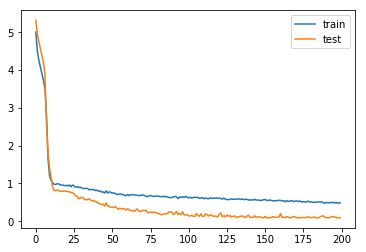

In [70]:
model1 = Sequential()
model1.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(loss='mae', optimizer='adam')
# fit network
history = model1.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [71]:
# make a prediction
yhat = model1.predict(test_X)
'''test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE'''
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.112


In [72]:
test_y

array([ 6.23504484,  6.3258907 ,  6.41777399,  6.53579333,  6.67201463,
        6.94754589,  7.00589263,  7.0815832 ,  7.20410361,  5.0347195 ,
        5.12540642,  5.18941311,  5.33055417,  5.44257229,  5.52728116,
        5.66173494,  5.77476796,  5.91013936,  5.9584035 ,  6.36761037,
        6.53189157,  6.72372139,  6.82253709,  5.43544947,  5.60531591,
        5.79265428,  6.10631702,  6.22365103,  6.35828541,  6.42990866,
        6.48758835,  6.52062719,  6.64844293,  6.73585155,  6.90164716,
        6.97516474,  7.03284629,  7.18119166,  7.36491296,  7.43791836,
        7.52034642,  5.08633637,  5.23148721,  5.35438141,  5.44660287,
        5.51452693,  5.57549254,  5.6370225 ,  6.23696309,  6.40213622,
        6.44125446,  6.48634769,  6.56332213,  6.62843013,  6.70353153,
        6.7496753 ,  6.81567764,  6.92107396,  6.98257684,  6.98267007,
        7.0347966 ,  7.08046283,  5.08553208,  5.14952942,  5.16308751,
        5.2415678 ,  5.29675312,  5.34666833,  5.50194097,  5.58

In [73]:
yhat

array([[ 6.30114937],
       [ 6.3841176 ],
       [ 6.47459078],
       [ 6.58271646],
       [ 6.764328  ],
       [ 6.99248123],
       [ 7.00489712],
       [ 7.01668596],
       [ 7.18511438],
       [ 5.3842659 ],
       [ 5.07836056],
       [ 5.12639427],
       [ 5.26330709],
       [ 5.3984766 ],
       [ 5.47374821],
       [ 5.52623844],
       [ 5.71365261],
       [ 5.7004652 ],
       [ 5.85068321],
       [ 6.26006126],
       [ 6.45247507],
       [ 6.59043837],
       [ 6.64273787],
       [ 5.35185862],
       [ 5.4993906 ],
       [ 5.72799301],
       [ 6.03776503],
       [ 6.15395117],
       [ 6.22058105],
       [ 6.35694313],
       [ 6.41162777],
       [ 6.38453245],
       [ 6.51006126],
       [ 6.6513958 ],
       [ 6.76337624],
       [ 6.83298349],
       [ 6.88838625],
       [ 7.05040121],
       [ 7.15063238],
       [ 7.23090172],
       [ 7.28970146],
       [ 5.59206295],
       [ 5.2414484 ],
       [ 5.35560799],
       [ 5.41248274],
       [ 5

In [82]:
reframed2 = reframed.drop(reframed.columns[[9,10,11,12,13]], axis=1)
print(reframed2.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   4.249634   2.999878        0.0        0.0   0.371230   0.696677   
2   4.409720   2.839792       11.0        0.0   0.220883   0.527402   
3   4.482361   2.767151       22.0        0.0   0.141776   0.477051   
4   4.542626   2.706886       33.0        0.0   0.156459   0.513401   
5   4.616296   2.633216       44.0        0.0   0.285218   0.638627   

   var7(t-1)   var1(t)   var2(t)  
1   0.136833  4.409720  2.839792  
2   0.062817  4.482361  2.767151  
3   0.055497  4.542626  2.706886  
4   0.066184  4.616296  2.633216  
5   0.158079  4.787174  2.462337  


In [83]:
# split into train and test sets
values = reframed2.values
n_train_hours = 2000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((2000, 1, 8), (2000,), (729, 1, 8), (729,))


Train on 2000 samples, validate on 729 samples
Epoch 1/200
0s - loss: 2.1222 - val_loss: 1.5206
Epoch 2/200
0s - loss: 1.8770 - val_loss: 1.2548
Epoch 3/200
0s - loss: 1.4629 - val_loss: 0.6645
Epoch 4/200
0s - loss: 0.8890 - val_loss: 0.5925
Epoch 5/200
0s - loss: 0.7760 - val_loss: 0.5905
Epoch 6/200
0s - loss: 0.7298 - val_loss: 0.6108
Epoch 7/200
0s - loss: 0.6818 - val_loss: 0.6201
Epoch 8/200
0s - loss: 0.6639 - val_loss: 0.6096
Epoch 9/200
0s - loss: 0.6483 - val_loss: 0.5967
Epoch 10/200
0s - loss: 0.6553 - val_loss: 0.5966
Epoch 11/200
0s - loss: 0.6238 - val_loss: 0.5887
Epoch 12/200
0s - loss: 0.6314 - val_loss: 0.5259
Epoch 13/200
0s - loss: 0.6236 - val_loss: 0.4933
Epoch 14/200
0s - loss: 0.5618 - val_loss: 0.4486
Epoch 15/200
0s - loss: 0.5410 - val_loss: 0.4127
Epoch 16/200
0s - loss: 0.5046 - val_loss: 0.3690
Epoch 17/200
0s - loss: 0.4679 - val_loss: 0.3232
Epoch 18/200
0s - loss: 0.4449 - val_loss: 0.2981
Epoch 19/200
0s - loss: 0.4351 - val_loss: 0.2674
Epoch 20/200

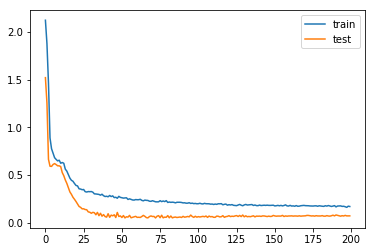

In [84]:
model2 = Sequential()
model2.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dropout(0.2))
model2.add(Dense(1))
model2.compile(loss='mae', optimizer='adam')
# fit network
history = model2.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [85]:
yhat = model2.predict(test_X)
'''test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE'''
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.110


In [86]:
# invert scaling for forecast
yhat

array([[ 1.40554261],
       [ 1.35430384],
       [ 1.25523138],
       [ 1.12743843],
       [ 1.00232553],
       [ 0.88083148],
       [ 0.85113049],
       [ 0.83030927],
       [ 0.80827045],
       [ 2.56290817],
       [ 2.68588519],
       [ 2.62098026],
       [ 2.4967165 ],
       [ 2.40254784],
       [ 2.34296465],
       [ 2.17160511],
       [ 2.10919857],
       [ 1.91864085],
       [ 1.90183711],
       [ 1.48258853],
       [ 1.31463909],
       [ 1.11387169],
       [ 1.03632867],
       [ 2.48130846],
       [ 2.22098923],
       [ 2.07750535],
       [ 1.7511636 ],
       [ 1.6401509 ],
       [ 1.46235919],
       [ 1.41694772],
       [ 1.35520482],
       [ 1.32453799],
       [ 1.20194805],
       [ 1.11743891],
       [ 0.99113756],
       [ 0.92746139],
       [ 0.90281975],
       [ 0.86356813],
       [ 0.82731235],
       [ 0.79684108],
       [ 0.77769899],
       [ 2.50541878],
       [ 2.55465937],
       [ 2.42709064],
       [ 2.35109329],
       [ 2

In [87]:
test_y

array([ 1.35577547,  1.26492962,  1.17304632,  1.05502698,  0.91880568,
        0.64327443,  0.58492769,  0.50923711,  0.3867167 ,  2.85395238,
        2.76326545,  2.69925877,  2.5581177 ,  2.44609959,  2.36139072,
        2.22693694,  2.11390392,  1.97853251,  1.93026837,  1.5210615 ,
        1.35678031,  1.16495049,  1.06613479,  2.4429685 ,  2.27310206,
        2.08576369,  1.77210095,  1.65476694,  1.52013256,  1.44850931,
        1.39082961,  1.35779078,  1.22997504,  1.14256642,  0.9767708 ,
        0.90325323,  0.84557168,  0.69722631,  0.513505  ,  0.44049961,
        0.35807154,  2.73544098,  2.59029014,  2.46739593,  2.37517448,
        2.30725041,  2.24628481,  2.18475484,  1.58481426,  1.41964112,
        1.38052288,  1.33542965,  1.25845521,  1.19334722,  1.11824581,
        1.07210205,  1.00609971,  0.90070339,  0.8392005 ,  0.83910728,
        0.78698074,  0.74131452,  2.76456557,  2.70056824,  2.68701015,
        2.60852985,  2.55334453,  2.50342932,  2.34815669,  2.26

In [101]:
reframed3 = reframed.drop(reframed.columns[[7,8,9,11,12,13]], axis=1)
print(reframed3.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   4.249634   2.999878        0.0        0.0   0.371230   0.696677   
2   4.409720   2.839792       11.0        0.0   0.220883   0.527402   
3   4.482361   2.767151       22.0        0.0   0.141776   0.477051   
4   4.542626   2.706886       33.0        0.0   0.156459   0.513401   
5   4.616296   2.633216       44.0        0.0   0.285218   0.638627   

   var7(t-1)  var4(t)  
1   0.136833      0.0  
2   0.062817      0.0  
3   0.055497      0.0  
4   0.066184      0.0  
5   0.158079      0.0  


In [102]:
# split into train and test sets
n_train_hours = 2000
train = reframed3.iloc[:n_train_hours, :]
test = reframed3.iloc[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((2000, 7), (2000,), (729, 7), (729,))


('training time: ', datetime.timedelta(0, 0, 112345))
('testing time: ', datetime.timedelta(0, 0, 1261))
classification report: 
             precision    recall  f1-score   support

        0.0       0.96      0.96      0.96       688
        1.0       0.37      0.37      0.37        41

avg / total       0.93      0.93      0.93       729

f1 score
0.664031480431
accuracy score
0.928669410151
confusion matrix:
[[662  26]
 [ 26  15]]


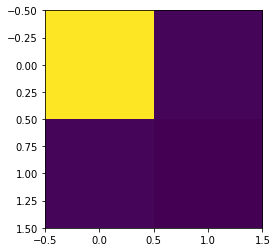

In [103]:
def testClassifier(x_train, y_train, x_test, y_test, clf):
    """
    this method will first train the classifier on the training data
    and will then test the trained classifier on test data.
    Finally it will report some metrics on the classifier performance.
    
    Parameters:
    
    x_train: (np.ndarray) train data matrix
    
    y_train: (list) train data label
    
    x_test: (np.ndarray) test data matrix
    
    y_test: (list) test data label
    
    clf: sklearn classifier object implementing fit() and predict() methods
    
    Returns:

    metrics: list
             [training time, testing time, recall and precision for every class, macro-averaged F1 score]
    """
    metrics = []
    start = dt.now()
    clf.fit(x_train, y_train)
    end = dt.now()
    print ('training time: ', (end - start))
    
    # add training time to metrics
    metrics.append(end-start)
    
    start = dt.now()
    pred = clf.predict(x_test)
    end = dt.now()
    print( 'testing time: ', (end - start))
    
    # add testing time to metrics
    metrics.append(end-start)
    
    print( 'classification report: ')
    # print classification_report(y_test, yhat)
    print (classification_report(y_test, pred))
    
    print ('f1 score')
    print (f1_score(y_test, pred, average='macro'))
    
    print ('accuracy score')
    print (accuracy_score(y_test, pred))
    
    precision = precision_score(y_test, pred, average=None)
    recall = recall_score(y_test, pred, average=None)
    
    # add precision and recall values to metrics
    for p, r in zip(precision, recall):
        metrics.append(p)
        metrics.append(r)
    
    
    #add macro-averaged F1 score to metrics
    metrics.append(f1_score(y_test, pred, average='macro'))
    
    print ('confusion matrix:')
    print (confusion_matrix(y_test, pred))
    
    # plotting the confusion matrix
    plt.imshow(confusion_matrix(y_test, pred), interpolation='nearest')
    plt.show()
    
    return metrics



gbm = GradientBoostingClassifier(n_estimators=35, learning_rate=.1,
                                max_depth=5, random_state=0, subsample=0.8, max_features=0.5)

# If we tune we can get more accuracy
boost = testClassifier(train_X, train_y, test_X, test_y, gbm)

('training time: ', datetime.timedelta(0, 0, 210336))
('testing time: ', datetime.timedelta(0, 0, 2765))
classification report: 
             precision    recall  f1-score   support

        0.0       0.99      0.83      0.90       688
        1.0       0.24      0.90      0.38        41

avg / total       0.95      0.83      0.87       729

f1 score
0.641841768683
accuracy score
0.83401920439
confusion matrix:
[[571 117]
 [  4  37]]


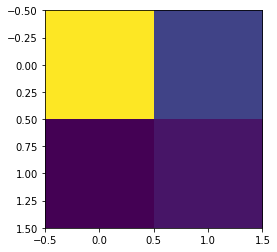

In [104]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate =0.1,
                     n_estimators=45,
                     max_depth=5,
                     min_child_weight=6,
                     gamma=0.1,
                     reg_alpha=0.01,
                     subsample=0.8,
                     colsample_bytree=0.9,
                     objective= 'binary:logistic',
                     scale_pos_weight=8,
                     seed=27)
xgboost = testClassifier(train_X, train_y, test_X, test_y, xgb)

In [105]:
train_X

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1)
1,4.249634,2.999878,0.0,0.0,0.371230,0.696677,0.136833
2,4.409720,2.839792,11.0,0.0,0.220883,0.527402,0.062817
3,4.482361,2.767151,22.0,0.0,0.141776,0.477051,0.055497
4,4.542626,2.706886,33.0,0.0,0.156459,0.513401,0.066184
5,4.616296,2.633216,44.0,0.0,0.285218,0.638627,0.158079
6,4.787174,2.462337,55.0,0.0,0.170063,0.725251,0.106769
7,4.902623,2.346889,66.0,0.0,0.164785,0.486677,0.066470
8,4.977155,2.272357,77.0,1.0,0.154474,0.755169,0.098450
9,4.171586,3.077926,88.0,0.0,0.457611,0.744114,0.347700
10,4.523625,2.725887,1.0,0.0,0.182251,0.530135,0.096914


In [111]:
test = pd.read_csv('gcPredictionFile.csv')
#test['CUMSUM_cputime'] = test['cpuTimeTaken'].cumsum(axis = 0)
test = test.merge(small, on='query token', right_index=True)
test = test.sort_index()
test = test.merge(ll, on='query token', right_index=True)
test = test.sort_index()
test['query token'] = encoder.fit_transform(test['query token'].astype('str'))
test['gcRun'] = encoder.fit_transform(test['gcRun'].astype('str'))
test.loc[:,['gcRun','cpuTimeTaken']] = test.loc[:,['cpuTimeTaken','gcRun']].values
test.columns = cols

In [112]:
test.fillna(value=0, inplace=True)

In [113]:
test.head()

,initialUsedMemory,initialFreeMemory,query token,gcRun,cpuTimeTaken,freq_y,diff_y
0,4.247186,2.774299,2,0.0,0.408436,0.520126,0.098823
1,0.000000,0.000000,73,0.0,0.124429,0.522675,0.044418
2,0.000000,0.000000,48,0.0,0.245838,0.468081,0.047545
3,0.000000,0.000000,86,0.0,0.169346,0.674019,0.125974
4,0.000000,0.000000,67,0.0,0.296311,0.732314,0.240021


In [114]:
test = series_to_supervised(test, 1, 1)

In [115]:
test.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,4.247186,2.774299,2.0,0.0,0.408436,0.520126,0.098823,0.0,0.0,73,0.0,0.124429,0.522675,0.044418
2,0.000000,0.000000,73.0,0.0,0.124429,0.522675,0.044418,0.0,0.0,48,0.0,0.245838,0.468081,0.047545
3,0.000000,0.000000,48.0,0.0,0.245838,0.468081,0.047545,0.0,0.0,86,0.0,0.169346,0.674019,0.125974
4,0.000000,0.000000,86.0,0.0,0.169346,0.674019,0.125974,0.0,0.0,67,0.0,0.296311,0.732314,0.240021
5,0.000000,0.000000,67.0,0.0,0.296311,0.732314,0.240021,0.0,0.0,18,0.0,0.025018,0.497912,0.013522


In [116]:
# drop columns we don't want to predict
test = test.drop(reframed.columns[[8,9,10,11,12,13]], axis=1)
print(test.head())
column = test.columns

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   4.247186   2.774299        2.0        0.0   0.408436   0.520126   
2   0.000000   0.000000       73.0        0.0   0.124429   0.522675   
3   0.000000   0.000000       48.0        0.0   0.245838   0.468081   
4   0.000000   0.000000       86.0        0.0   0.169346   0.674019   
5   0.000000   0.000000       67.0        0.0   0.296311   0.732314   

   var7(t-1)  var1(t)  
1   0.098823      0.0  
2   0.044418      0.0  
3   0.047545      0.0  
4   0.125974      0.0  
5   0.240021      0.0  


In [117]:
final = test.copy()

In [128]:
for i in range(test.shape[0]):
    gc = test['var4(t-1)'][i] = gbm.predict(test.iloc[i:i+1,:7])
    test = test.values
    test = test.reshape((test.shape[0], 1, test.shape[1]))
    ffm = test[i+1:i+2,:,0] = test[i:i+1,:,7:] = model1.predict(test[i:i+1,:,:7])
    fum = test[i+1:i+2,:,1] = model2.predict(test[i:i+1])
    test = test.reshape((test.shape[0], test.shape[2]))
    test = pd.DataFrame(test)
    test.columns = column
    print(gc, ffm, fum)

(array([ 0.]), array([[ 4.71317434]], dtype=float32), array([[ 2.67545509]], dtype=float32))
(array([ 0.]), array([[ 5.03791428]], dtype=float32), array([[ 2.65668106]], dtype=float32))
(array([ 0.]), array([[ 5.2091074]], dtype=float32), array([[ 2.57024074]], dtype=float32))
(array([ 0.]), array([[ 5.34451437]], dtype=float32), array([[ 2.44717121]], dtype=float32))
(array([ 0.]), array([[ 5.58297348]], dtype=float32), array([[ 2.22319889]], dtype=float32))
(array([ 0.]), array([[ 5.52365303]], dtype=float32), array([[ 2.23569918]], dtype=float32))
(array([ 0.]), array([[ 5.60565662]], dtype=float32), array([[ 2.19286633]], dtype=float32))
(array([ 0.]), array([[ 5.75982761]], dtype=float32), array([[ 2.05823159]], dtype=float32))
(array([ 0.]), array([[ 5.82366943]], dtype=float32), array([[ 2.0105691]], dtype=float32))
(array([ 0.]), array([[ 5.87385654]], dtype=float32), array([[ 1.92753887]], dtype=float32))
(array([ 0.]), array([[ 6.01774502]], dtype=float32), array([[ 1.7748723

In [129]:
test

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
0,4.247186,2.774299,2.0,0.0,0.408436,0.520126,0.098823,4.713174
1,4.713174,2.675455,73.0,0.0,0.124429,0.522675,0.044418,5.037914
2,5.037914,2.656681,48.0,0.0,0.245838,0.468081,0.047545,5.209107
3,5.209107,2.570241,86.0,0.0,0.169346,0.674019,0.125974,5.344514
4,5.344514,2.447171,67.0,0.0,0.296311,0.732314,0.240021,5.582973
5,5.582973,2.223199,18.0,0.0,0.025018,0.497912,0.013522,5.523653
6,5.523653,2.235699,33.0,0.0,0.121191,0.513401,0.066184,5.605657
7,5.605657,2.192866,43.0,0.0,0.220577,0.660618,0.150208,5.759828
8,5.759828,2.058232,72.0,0.0,0.133468,0.526436,0.077532,5.823669
9,5.823669,2.010569,24.0,0.0,0.151191,0.578549,0.095986,5.873857


In [130]:
initialFreeMemory = test['var2(t-1)'].copy()
gcRun = test['var4(t-1)'].copy()

In [131]:
gcRun[13] == 1

False

In [132]:
for i in range(1624):
    if gcRun[i] == 1:
        gcRun[i] = 'True'
    else:
        gcRun[i] = 'False'
        

In [133]:
sample_submission = pd.DataFrame({
        "serialNum": range(1,1625),
        "initialFreeMemory": initialFreeMemory,
        "gcRun": gcRun
    })

In [134]:
sample_submission = sample_submission[['serialNum', 'initialFreeMemory', 'gcRun']]
sample_submission

,serialNum,initialFreeMemory,gcRun
0,1,2.774299,False
1,2,2.675455,False
2,3,2.656681,False
3,4,2.570241,False
4,5,2.447171,False
5,6,2.223199,False
6,7,2.235699,False
7,8,2.192866,False
8,9,2.058232,False
9,10,2.010569,False


In [135]:
df = DataFrame(columns=('serialNum', 'initialFreeMemory', 'gcRun'))
df.loc[1624] = [1625, 1.0525423, False]
df

,serialNum,initialFreeMemory,gcRun
1624,1625,1.052542,False


In [136]:
sample_submission = pd.concat([sample_submission,df], axis=0)
sample_submission

,serialNum,initialFreeMemory,gcRun
0,1,2.774299,False
1,2,2.675455,False
2,3,2.656681,False
3,4,2.570241,False
4,5,2.447171,False
5,6,2.223199,False
6,7,2.235699,False
7,8,2.192866,False
8,9,2.058232,False
9,10,2.010569,False


In [137]:
sample_submission.to_csv('gbm.csv', index=False)

In [163]:
test = test.values

In [164]:
test = test.reshape((test.shape[0], 1, test.shape[1]))

In [165]:
test.shape

(1624, 1, 9)

In [168]:
test[1:2,:,0]

array([[ 0.]])

In [71]:
model1.predict(test[0:1])

array([[ 4.43321514]], dtype=float32)

In [151]:
test = test.reshape((test.shape[0], test.shape[2]))
test

array([[  4.24718574e+00,   2.77429863e+00,   2.00000000e+00, ...,
          5.20125801e-01,   9.88234557e-02,   4.43321514e+00],
       [  0.00000000e+00,   0.00000000e+00,   7.30000000e+01, ...,
          5.22675028e-01,   4.44181414e-02,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   4.80000000e+01, ...,
          4.68080782e-01,   4.75453128e-02,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   3.30000000e+01, ...,
          5.13401165e-01,   6.61844581e-02,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   7.70000000e+01, ...,
          7.55169284e-01,   9.84503234e-02,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   5.50000000e+01, ...,
          7.25251011e-01,   1.06768641e-01,   0.00000000e+00]])

In [68]:
test[0]

array([[ 4.24718574,  2.77429863,  2.        ,  0.        ,  0.40843588,
         0.40843588,  0.5201258 ,  0.09882346]])

In [ ]:
test[1:2,:,1]